In [10]:
from prophet import Prophet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
### Data processing

data = pd.read_excel('/home/stefan/PycharmProjects/LauzHack2024/BRISTOR_Zegoland.xlsx')

In [3]:
### Mocking the data

# Mock dataset creation based on the previous description
# Assuming monthly data from August 2020 to October 2024 for "Ex-factory volumes"
date_range = pd.date_range(start="2020-08-01", end="2024-10-31", freq="M")
mock_data = {
    'ds': date_range,
    'y': [abs(100 + (x % 12) * 10 + (x % 5) * 5 - (x % 3) * 2) for x in range(len(date_range))],  # Mock 'Ex-factory volumes'
    'demand_volumes': [50 + (x % 12) * 2 for x in range(len(date_range))],  # Mock 'Demand volumes'
    'activity': [10 + (x % 6) * 3 for x in range(len(date_range))],  # Mock 'Activity'
    'share_of_voice': [0.3 + (x % 4) * 0.05 for x in range(len(date_range))],
    'competitor_impact': [0] * len(date_range)# Mock 'Share of Voice'
}

# Define competitor impact starting 6 months from the last date
event_start = pd.to_datetime("2025-04-01")
for i, date in enumerate(date_range):
    if date >= event_start:
        data['competitor_impact'][i] = -0.1  # Assuming a 10% drop in sales


# Convert to DataFrame
df = pd.DataFrame(mock_data)

/tmp/ipykernel_236452/1923141652.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start="2020-08-01", end="2024-10-31", freq="M")


In [4]:
### Initializing the Prophet model
model = Prophet() # TODO tweak parameters
model.add_regressor('demand_volumes')
model.add_regressor('activity')
model.add_regressor('share_of_voice')
model.add_regressor('competitor_impact') # If a competitor releases a new product


# Fit the model
model.fit(df)

# Create future DataFrame
future = model.make_future_dataframe(periods=12, freq="M")  # Forecast for next 12 months
future['demand_volumes'] = [60 + (x % 12) * 2 for x in range(len(future))]  # Future 'Demand volumes'
future['activity'] = [15 + (x % 6) * 3 for x in range(len(future))]  # Future 'Activity'
future['share_of_voice'] = [0.4 + (x % 4) * 0.05 for x in range(len(future))]  # Future 'Share of Voice'

# Add the impact of the competitor in the future
for i, date in enumerate(future['ds']):
    if date >= event_start:
        future.loc[i, 'competitor_impact'] = -0.1  # Future impact
    else:
        future.loc[i, 'competitor_impact'] = 0
        
# Adjust SoV for competitor impact
for i, date in enumerate(future['ds']): # TODO fix the share of voice
    if date >= event_start:
        future.loc[i, 'share_of_voice'] *= 0.9  # Reduce SoV by 10%

# Make predictions
forecast = model.predict(future)

# Display forecasted results
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)  # Last 12 rows for predictions


16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] done processing
/home/stefan/miniconda3/envs/LauzHack2024/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
51,2024-11-30,432.328356,424.977492,440.036324
52,2024-12-31,450.185192,442.245421,458.748532
53,2025-01-31,445.921258,438.140089,453.145418
54,2025-02-28,463.110533,455.449683,470.879826
55,2025-03-31,476.023955,467.683013,484.099814
56,2025-04-30,382.053936,374.681208,389.446377
57,2025-05-31,378.236463,370.217615,386.209613
58,2025-06-30,371.039533,363.311454,378.610184
59,2025-07-31,368.718953,360.641752,376.185567
60,2025-08-31,302.702464,295.237749,310.565372


In [13]:
### Showing the model coefficients for each regression term 

# Number of Fourier terms for each seasonality
yearly_seasonality_order = 10  # Default if you didn't change `fourier_order`
weekly_seasonality_order = 3   # Default weekly seasonality (adjust if custom)

# Total seasonal terms
seasonal_terms = yearly_seasonality_order + weekly_seasonality_order

# Extract external regressor coefficients
external_regressor_coefficients = model.params['beta'][:, seasonal_terms:].flatten()  # Remove seasonal terms

# Map to the names of regressors
#regressor_names = ['adjusted_share_of_voice', 'activity']  # Your defined regressors
regressor_names = ['demand_volumes', 'activity', 'share_of_voice', 'competitor_impact', 'adjusted_share_of_voice']
relationship_df = pd.DataFrame({
    'Regressor': regressor_names,
    'Coefficient': external_regressor_coefficients[:len(regressor_names)]
})

print(relationship_df)


                 Regressor  Coefficient
0           demand_volumes    -0.024047
1                 activity     0.235947
2           share_of_voice     0.116732
3        competitor_impact     0.146291
4  adjusted_share_of_voice     0.046532


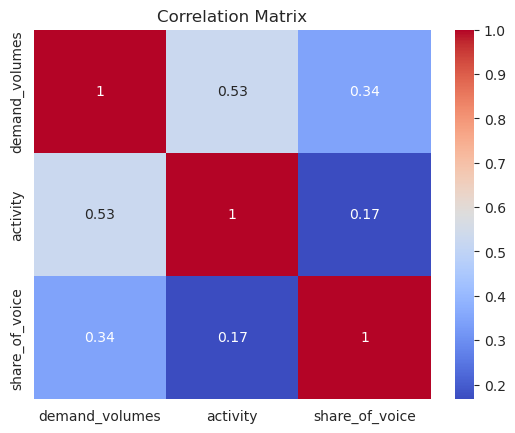

In [21]:
### CORRELATION MATRIX


regressor_names_historic_data = ['demand_volumes', 'activity', 'share_of_voice']
# Correlation heatmap
correlation_matrix = df[regressor_names_historic_data].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()